## **Import Library**

In [30]:
!pip install torch
!pip install torch-geometric

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [33]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer

import torch
from scipy.sparse import csr_matrix
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## **Read Data**

In [3]:
# Load the .mat file
mat = scipy.io.loadmat('qm7.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])

In [4]:
# Extract the variables
X = mat['X']  # Feature matrix
R = mat['R']  # Cartesian coordinates
Z = mat['Z']  # Atomic numbers
T = mat['T']  # Atomization energies (label)
P = mat['P']  # Other properties

## **Change Shape**

In [5]:
R_flattened = R.reshape(R.shape[0], -1)
X_flattened = X.reshape(X.shape[0], -1)

In [6]:
Z

array([[6., 1., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]], dtype=float32)

In [7]:
def one_hot_encode_Z(Z):
    num_samples, num_atoms = Z.shape
    max_atom_type = int(np.max(Z)) + 1
    encoder = OneHotEncoder(categories=[range(max_atom_type)], sparse=False)
    Z_reshaped = Z.reshape(-1, 1)
    Z_encoded = encoder.fit_transform(Z_reshaped).reshape(num_samples, num_atoms * max_atom_type)
    return Z_encoded

Z_encoded = one_hot_encode_Z(Z)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
print(X_flattened.shape)
print(R_flattened.shape)
print(Z_encoded.shape)
print(P.shape)

(7165, 529)
(7165, 69)
(7165, 391)
(5, 1433)


In [9]:
P_reshape = P.reshape(7165, -1)
print(P_reshape.shape)

(7165, 1)


In [10]:
# Concatenate trimmed arrays
all_features = np.hstack((X_flattened, R_flattened, Z_encoded, P_reshape))
print(f"All features shape after trimming: {all_features.shape}")

All features shape after trimming: (7165, 990)


## **Convert to csv file**

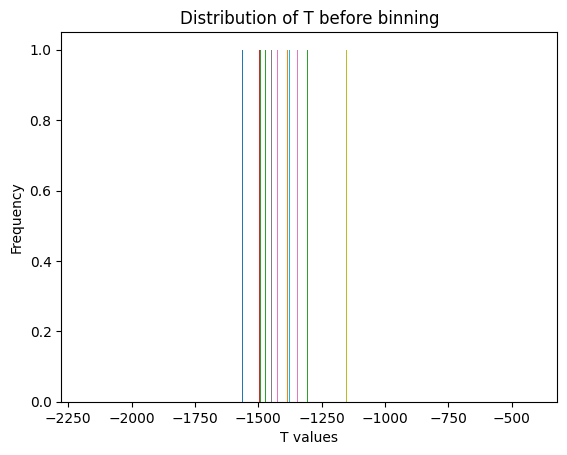

In [ ]:
plt.hist(T, bins=50)
plt.title('Distribution of T before binning')
plt.xlabel('T values')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Check the shape of the concatenated data
print(data.shape)

# Define the feature matrix X and target vector y
X = data[:, :-1]
y = data[:, -1]

# Check the distribution of y
print(np.unique(y, return_counts=True))

(7165, 991)
(array([0., 1., 2., 3., 4.]), array([ 728, 3631, 2593,  201,   12]))


In [ ]:
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('Features.csv', index=False)

In [15]:
df2=pd.read_csv('Features.csv')
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,981,982,983,984,985,986,987,988,989,Label
0,36.858105,2.907633,2.907612,2.907564,2.905349,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5578.0,-417.96
1,36.858105,12.599944,2.902000,1.473118,1.473101,2.901973,2.901886,1.473102,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2504.0,-712.42
2,36.858105,14.261827,1.503703,2.924997,2.924732,1.503680,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4851.0,-564.21
3,36.858105,15.871878,2.979434,1.401225,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3130.0,-404.88
4,73.516693,17.885317,10.561490,4.355064,2.062530,2.069614,1.581991,1.590780,1.261482,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6670.0,-808.87


In [16]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,...,981,982,983,984,985,986,987,988,989,Label
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,...,7165.0,7165.0,7165.0,7165.0,7165.0,7165.0,7165.0,7165.0,7165.000000,7165.000000
mean,78.447518,13.247392,13.651229,12.761609,11.313269,9.741235,7.374219,1.992688,1.709067,1.595967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3582.000000,-1538.037630
std,65.448339,6.134428,6.168350,5.406752,4.984658,4.785995,4.318243,0.912114,0.721890,0.698753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2068.501672,223.934546
min,36.858105,2.907633,1.503703,1.172837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-2192.000000
25%,53.358707,9.065171,9.293125,9.019773,7.737596,6.671409,4.668823,1.421404,1.297994,1.192658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1791.000000,-1704.230000
50%,73.516693,12.434812,12.495984,10.668070,10.247300,8.685217,6.669063,1.717358,1.562530,1.470488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3582.000000,-1544.380000
75%,73.516693,15.262316,17.618086,17.504143,14.998941,10.677979,9.189721,2.049483,1.957705,1.774468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5373.000000,-1385.890000
max,388.023438,47.143398,47.179157,47.015327,29.794344,29.790239,29.617144,4.379876,4.373618,4.364484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7164.000000,-404.880000


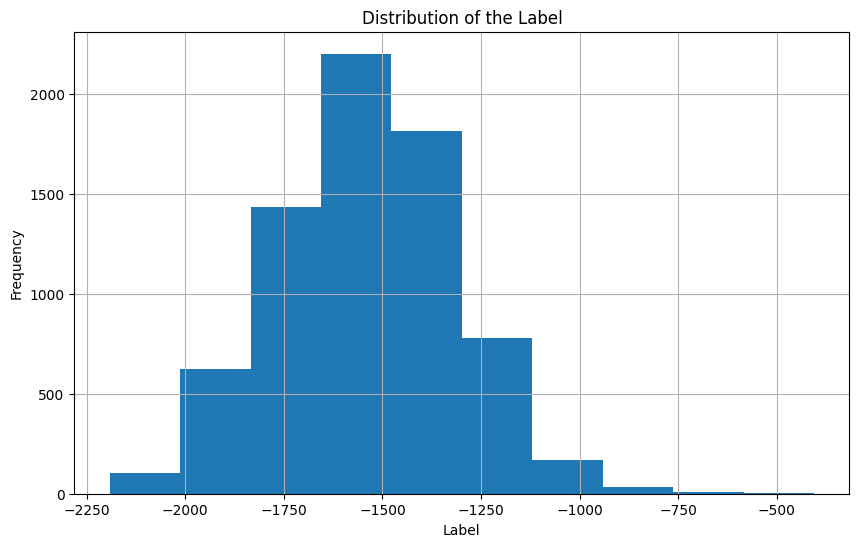

In [18]:
plt.figure(figsize=(10, 6))
df2['Label'].hist()
plt.title('Distribution of the Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

## **Run on Machine Learning Models**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
models = {
    'KernelRidge': KernelRidge(),
    'SVR': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': xgb.XGBRegressor(n_estimators=200)
}

kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [21]:
def evaluate_model(model, X, y, cv):
    mse = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv).mean()
    r2 = cross_val_score(model, X, y, scoring='r2', cv=cv).mean()
    return mse, r2

In [22]:
results = {}
for model_name, model in models.items():
    # Cross-validation scores
    mse_cv, r2_cv = evaluate_model(model, X_train, y_train, kf)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        'MSE (CV)': mse_cv,
        'R2 Score (CV)': r2_cv,
        'MSE (Test)': mse_test,
        'R2 Score (Test)': r2_test
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                      MSE (CV)  R2 Score (CV)    MSE (Test)  R2 Score (Test)
KernelRidge       5.762774e-02   8.806017e-01  5.992689e-02     8.795061e-01
SVR               4.459163e-01   7.817354e-02  4.369591e-01     1.214143e-01
LinearRegression  1.258511e+14  -2.576485e+14  1.007976e+13    -2.026720e+13
XGBRegressor      2.331530e-02   9.517425e-01  2.420796e-02     9.513255e-01


## **Visualize Result**

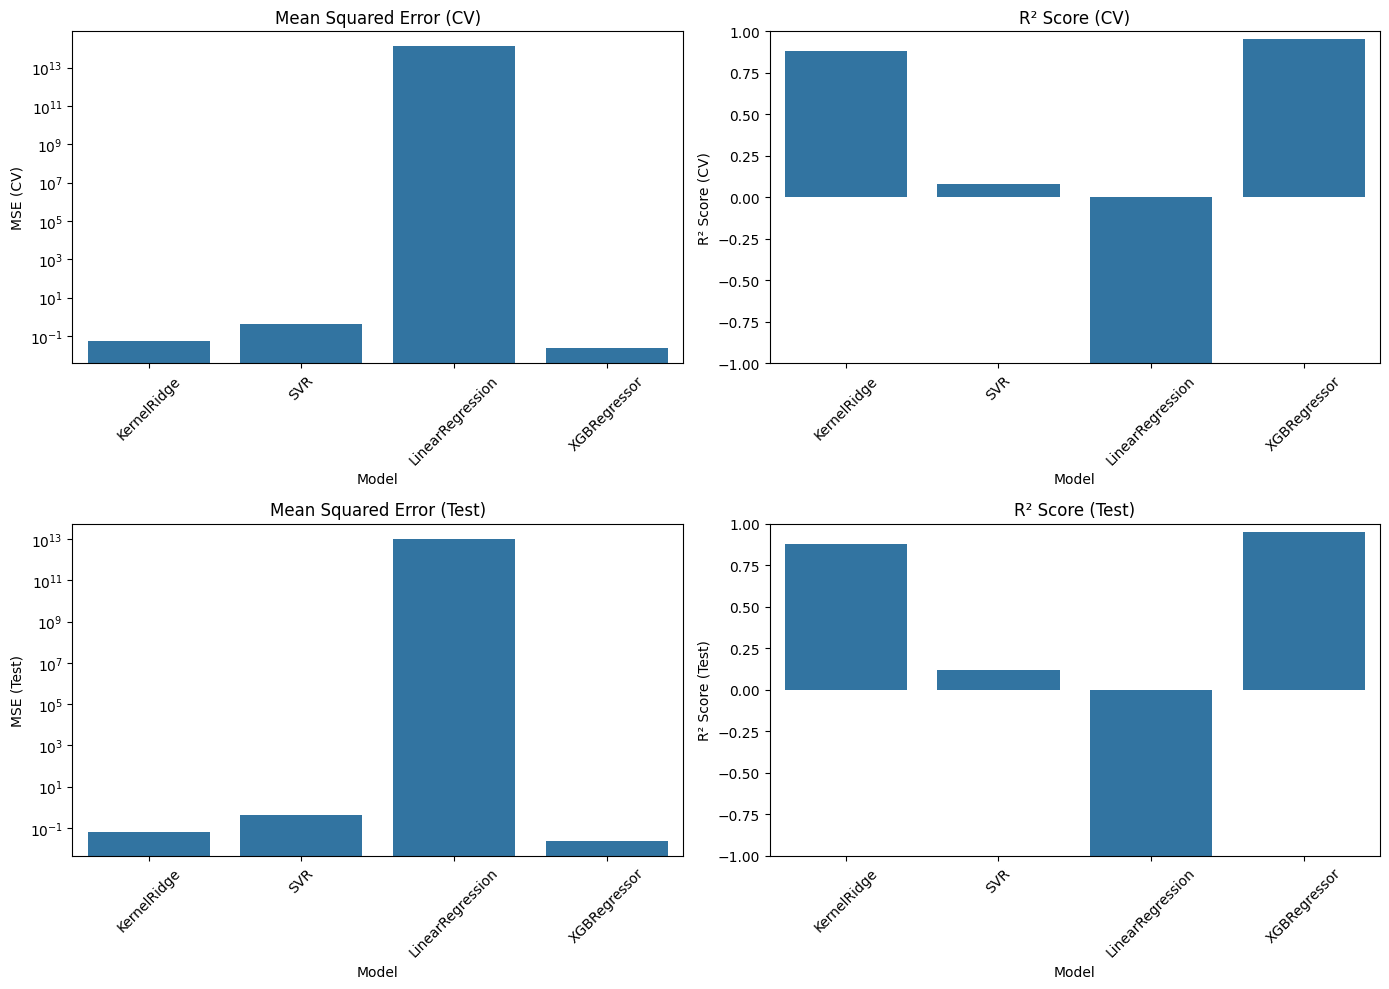

In [45]:
plt.figure(figsize=(14, 10))

# MSE (CV)
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df['MSE (CV)'])
plt.title('Mean Squared Error (CV)')
plt.xlabel('Model')
plt.ylabel('MSE (CV)')
plt.yscale('log')
plt.xticks(rotation=45)

# R² Score (CV)
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df['R2 Score (CV)'])
plt.title('R² Score (CV)')
plt.xlabel('Model')
plt.ylabel('R² Score (CV)')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

# MSE (Test)
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y=results_df['MSE (Test)'])
plt.title('Mean Squared Error (Test)')
plt.xlabel('Model')
plt.ylabel('MSE (Test)')
plt.yscale('log')
plt.xticks(rotation=45)

# R² Score (Test)
plt.subplot(2, 2, 4)
sns.barplot(x=results_df.index, y=results_df['R2 Score (Test)'])
plt.title('R² Score (Test)')
plt.xlabel('Model')
plt.ylabel('R² Score (Test)')
plt.ylim(-1, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **GNN**

In [35]:
# Convert train and test data into sparse matrix
sparse_matrix_train = csr_matrix(X_train)
sparse_matrix_test = csr_matrix(X_test)

# Convert sparse matrix into dense matrix
node_features_train = torch.tensor(sparse_matrix_train.toarray(), dtype=torch.float)
node_features_test = torch.tensor(sparse_matrix_test.toarray(), dtype=torch.float)

# Convert dense matrix into sparse representation
edge_index_train, edge_attr_train = dense_to_sparse(node_features_train)
edge_index_test, edge_attr_test = dense_to_sparse(node_features_test)

# Convert labels into tensor
labels_train = torch.tensor(y_train, dtype=torch.float)
labels_test = torch.tensor(y_test, dtype=torch.float)

print(f"Train Edge Index:\n{edge_index_train}")
print(f"Train Node Features Shape: {node_features_train.shape}")
print(f"Train Labels Shape: {labels_train.shape}")


Train Edge Index:
tensor([[   0,    0,    0,  ..., 5731, 5731, 5731],
        [   0,    1,    2,  ...,  955,  972,  989]])
Train Node Features Shape: torch.Size([5732, 990])
Train Labels Shape: torch.Size([5732])


In [37]:
class GCNRegression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNRegression, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, node_features, edge_index):
        x = self.conv1(node_features, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [56]:
model = GCNRegression(input_dim=node_features_train.shape[1], hidden_dim=64, output_dim=1)

# Use Adam optimizer and Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [57]:
# List to store loss values
train_losses = []

# Training loop with loss storage
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(node_features_train, edge_index_train).squeeze()
    loss = criterion(out, labels_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 12253760.0
Epoch 5, Loss: 464262.0
Epoch 10, Loss: 839889.375
Epoch 15, Loss: 91193.9140625
Epoch 20, Loss: 160084.453125
Epoch 25, Loss: 101010.9453125
Epoch 30, Loss: 16776.87890625
Epoch 35, Loss: 54248.2734375
Epoch 40, Loss: 217.2305908203125
Epoch 45, Loss: 18523.529296875
Epoch 50, Loss: 4434.42138671875
Epoch 55, Loss: 2441.071533203125
Epoch 60, Loss: 4410.97265625
Epoch 65, Loss: 278.8053894042969
Epoch 70, Loss: 1111.842041015625
Epoch 75, Loss: 966.9910888671875
Epoch 80, Loss: 150.8822784423828
Epoch 85, Loss: 336.87969970703125
Epoch 90, Loss: 327.476806640625
Epoch 95, Loss: 146.67642211914062


In [58]:
# After training, evaluate and visualize the predictions
model.eval()
with torch.no_grad():
    output_test = model(node_features_test, edge_index_test).squeeze()
    mse_test = criterion(output_test, labels_test).item()
    print(f'Test Mean Squared Error: {mse_test}')

    # Convert tensors to numpy for plotting
    output_test_np = output_test.cpu().numpy()
    labels_test_np = labels_test.cpu().numpy()


Test Mean Squared Error: 69.73665618896484


## **Visualize Result**

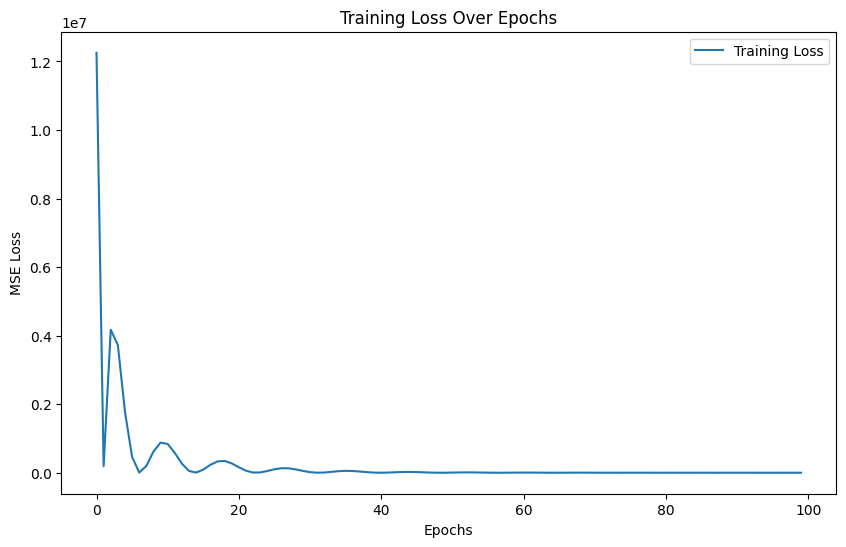

In [59]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

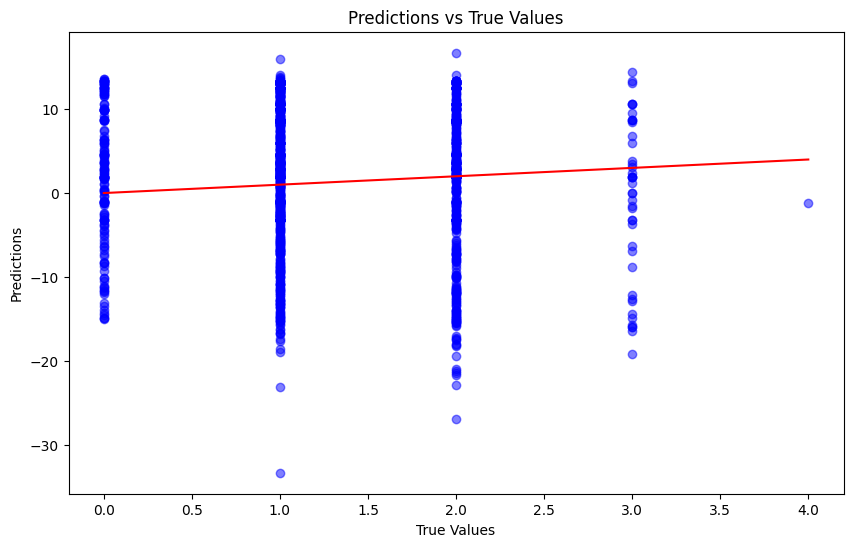

In [60]:
# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(labels_test_np, output_test_np, color='blue', alpha=0.5)
plt.plot([min(labels_test_np), max(labels_test_np)], [min(labels_test_np), max(labels_test_np)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()